# Chaper 3. Linear Neural Networks

## Linear Regression

- 의존적인 하나의 변수(Output) <-> 하나 혹은 다수의 독립적 변수들(Input)간의 관계를 모델링하는 것.
- Input과 Output간의 관계의 특성을 추출하는 것. 
- Numerical Value를 예측하는 경우 주로 사용됨.

### Linear Model
- 선형성 가정 (Linearity Assumption)
  > 어떤 문제에 대한 입력과 출력간의 관계가 선형 함수의 합에 의해 표현 될 수 있다. (weighted sum of features)
  
### Loss Function
- a Measure of fitness of model
- Training
  > optimal paramters = argmin Loss(w,b) => Loss 함수를 최소로만드는 parameter를 찾는것.
- 특이하게도 Linear Regression의 loss function을 최소화하는 문제는 분석적 방식으로 closed form을 유도할 수 있음. 


  



## Minibatch / SGD
- 선형 회귀와 같이 분석적인 방식으로 Optimal을 유도할 수 없어도 training이 가능한데 
- 간단히 말해서 loss function을 감소시키는 방향으로 점진적으로 파라미터를 업데이트해나가면 되는데 
- 이것이 Gradient Descent 
- Naive Gradient Descent 
  - 데이터셋의 모든 예시에 대해 Loss값의 평균을 구하고
  - 이렇게 얻은 평균에 대해 편미분을 구하여 paramer를 업데이트 
  - 한번 업데이트 하는데 모든 데이터를 다 훑어야 함 => 너무 느림
- Random Sampling 된 Batch를 Update의 기본 단위로하여 절충 => SGD
- Steps of Gradient Descent 
  - 파라미터 초기화 (Initialize weight and bias)
  - 각 batch에 대한 loss 대표값을 구함 (Calculate average loss for each batch (minibatch))
  - loss function에 대한 미분을 구하고 (Calculate derivitive)
  - 미분의 값에 learning rate를 반영하여 파라미터 업데이트 (paramtersUpdate parameters with amount of learning rate)
  - 미리 정한 횟수(epoch)만큼 위 학습을 반복함
- 여기서 learning rate나 batch size 같은 건 학습과정에 update되는 parameter가 아님.  => Hyperparamters

- Linear Regression은 하나의 Minimum이 존재하지만
- 보다 복잡한 모델이나 Deep Networks는 그렇지 않음
  > Hyperparamters 등의 tuning을 통해 loss function이 최소화 되는 조건을 찾아야 함
  



  

  
  

In [31]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# generate synthetic data 

def synthetic_data(w, b, num_samples): #@save
    X = torch.normal(0, 1, (num_samples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

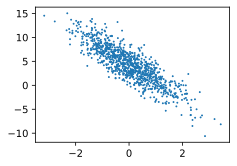

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

d2l.set_figsize()

d2l.plt.scatter(features[:,(1)].detach().numpy(), labels.detach().numpy(), 1)

In [39]:
# chop dataset into mini batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [40]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3161,  0.6896],
        [ 0.8479,  0.3523],
        [ 0.0338,  0.5933],
        [-0.5410,  0.3048],
        [-0.5494,  0.5204],
        [-0.3241,  0.1652],
        [ 0.7258,  0.6448],
        [-0.4174, -0.6200],
        [ 0.0702, -1.2007],
        [-1.8209, -0.2068]]) 
 tensor([[1.2036],
        [4.6973],
        [2.2436],
        [2.0740],
        [1.3415],
        [2.9660],
        [3.4691],
        [5.4640],
        [8.4075],
        [1.2445]])


In [56]:
# initialize paramters
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define model
def linreg(X, w, b): #@save
    return torch.mm(X,w) + b

In [47]:
def squared_loss(y_hat, y): #@save
    return (y_hat - y) ** 2 / 2

In [50]:
def sgd(params, lr, batch_size): #@save
    with torch.no_grad():    # disable gradient update 
        for param in params:
            param -= lr * param.grad / batch_size   # update parameters with gradient 
            param.grad.zero_()                      # set gradient to zero
    

In [52]:
# hyper parameters 
lr = 0.03 
num_epochs = 3
net = linreg
loss = squared_loss


In [57]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039157
epoch 2, loss 0.000146
epoch 3, loss 0.000048


In [61]:
print(f'error in w : {true_w - w.reshape(true_w.shape)}')
print(f'error in b : {true_b - b}')

error in w : tensor([ 0.0003, -0.0005], grad_fn=<SubBackward0>)
error in b : tensor([0.0008], grad_fn=<RsubBackward1>)


---
## Linear Regression using more PyTorch API


In [63]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [71]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features ,labels = d2l.synthetic_data(true_w, true_b, 1000)

In [76]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


In [78]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [79]:
next(iter(data_iter))

[tensor([[-1.1173, -0.3688],
         [-0.8666, -0.4940],
         [-0.4476, -1.1426],
         [ 1.6796,  1.3246],
         [ 0.1867, -0.4542],
         [-0.6351, -0.4539],
         [ 1.0691,  0.7836],
         [-0.6862, -0.3856],
         [-0.1263, -0.6634],
         [-0.0542,  0.0830]]),
 tensor([[3.2178],
         [4.1207],
         [7.1906],
         [3.0591],
         [6.1061],
         [4.4745],
         [3.6767],
         [4.1449],
         [6.1996],
         [3.8055]])]

In [81]:
# define Model
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

In [86]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [89]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [93]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in iter(data_iter):
        l = loss(y, net(X))
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch = {epoch}, l = {l:f}')
        

epoch = 0, l = 0.000096
epoch = 1, l = 0.000096
epoch = 2, l = 0.000096


## Softmax Regression
- classification 문제 (스팸 분류, dog/cat..)
### Class Assignment 종류
  - Hard assignment 
    > 입력에 대한 class를 예측
  - Soft assignment 
    > 입력에 대한 class의 확률을 예측
    
 > 실제 hard assignment를 구현하는데 있어서 soft assignment를 활용하기도 하기 때문에 이러한 구분은 큰 의미가 없어짐

### Network Architecture

  > linear regression과 유사한 single linear layer (FC)
  
  - 이러한 FC layer는 안쓰이는 곳이 없지만, 말그대로 FC이기 때문에 Parameter를 매우 많이 필요로 함. 
    
    > 나중에 배우겠지만 이러한 문제를 해결할 수 있는 절충안이 존재하긴함 

### Softmax Operation
  
  > Classification에서 출력은 임의의 클래스일 확률. 
  > 단순히 linear layer의 출력 값, logit을 사용할 수 없는것은..
  
  - 음수가 될 수 있으며 
  - 또한 출력된 확률의 합, 즉 어떤 입력에 대한 모든 가능한 class의 확률의 합이 1이 되도록 보장되지 않음
  
> 따라서 linear layer의 출력인 logits을 non-negative의 합쳐서 1이되도록 변환해 줄 방법이 필요

- 이를 위해 ```Softmax```함수를 사용하게 됨
> softmax(x in X) => exp(x) / sum of exp. of all the elements in X

- 그리고 임의의 set X에 대해 argmax(X)는 argmax(softmax(X)) 같다. 
- 비록 Softmax는 비선형 함수이지만 [affine transformation](https://www.mathworks.com/discovery/affine-transformation.html#:~:text=Affine%20transformation%20is%20a%20linear,with%20non%2Dideal%20camera%20angles.)이므로 전체 Softmax regression은 Linear Model이라 할 수 있음
  

  


In [7]:
# simple softmax
import numpy as np

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

logits = [-3.4, -2.1, 4]


softmax(logits), np.argmax(logits) == np.argmax(softmax(logits))

(array([6.09513137e-04, 2.23648452e-03, 9.97154002e-01]), True)

### Vectorization for minibatches
> GPU 등 연산 가속을 위해 주어진 batch size와 feature 갯수에 따라 모델의 parameter은 일정한 형태 (shape)의 vector 형태를 갖게된다. 이렇게 함으로써 matrix-matrix product 형태로 만들어서 가속화된다. 

### Loss function

- Log-Likelihood
  P(Y|X) : 주어진 X에 대해서 Y일 확률 => 정확도
  P(Y|X) = predict(X).reduce_product()
  -log(P(Y|X)) = -log(predict(X)).sum()
  
- 어찌어찌하면 loss function이 아래와 같이 됨
  l = -(y_label * np.log(y_pred)).sum() 

- 이를 **cross entroy loss**라 함
- 여기서 y_label는 one-hot vector이기 때문에 결국 하나의 class에 대한 성분만 남기고 다 사라짐
- y_pred는 확률이기 때문에 log(y_pred)는 절대 0보다 크지 않음 
- 따라서 loss function은 이상적인 예측 결과에 해당되는 값보다 더 작아 질 수 없음. (다시말해 확률이 1인 조건)

### Derivative of Softmax Function
- 어찌어찌 계산을 하면 softmax(o) - y 즉,  결과적으로 예측된 값과 Label의 차이가 softmax의 derivative 값이 됨
- 이러한 성질 때문에 gradient 연산이 매우 절약됨 



### 별첨. Entropy란?
> 정보 이론에서 어떠한 정보의 양을 측정하는 방법 중 하나로 어떠한 정보를 압축할 때에 절대적인 한계로써 인식됨.
> 이때 정보를 어떠한 확률분포(P)의 랜덤값으로 가정할때 (결국 어떠한 값들의 집합개념으로써...)

- P(j) : 어떤 임의의 값 j의 확률 밀도
entropy(P) = -sum( P(j) * log( P(j) ) )

> 그리고 이를 말로 풀면 ```어떤 확률 분포 P를 전송하기 위해 최소한 entropy(P)만큼의 nats이 필요함```
> 여기서 nats은 일종의 bit과 같은 개념이지만 2진법이 아닌 e(오일러수)를 base로 하는 단위 체계 1 nats = 1.44bit

#### 정보의양 = 예측의 빗나감 정도
- 만약 어떠한 값의 집합이 있을 때 하나의 값으로 부터 모든 집합의 값을 일정한 규칙을 통해 유추할 수 있다면 이러한 정보의 집합은 매우 효과적으로 압축될 수 있다. 가령 '정수'라고 이야기함으로써 그 안에 어떠한 정보가 담겨 있을지 완전히 예상할 수 있는 것처럼....
- entropy는 이러한 정보의 특징을 모델링한 것 즉, 이러한 예측의 빗나감 (surprisal)의 기대값

## The Image Classification Dateset
> 1998 Yan LeCun 등에 의해 구축된 MNIST Dataset이 널리 사용되었지만 아무리 단순한 모델이라 하더라도 95%이상을 쉽게 달성하기 때문에 변별력이 없다. 때문에 Fashion-MNIST를 사용한다. 



  
 


In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l 

d2l.use_svg_display()

### Reading the Dataset

In [3]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../../data", 
                                                train=True, 
                                                transform=trans, 
                                                download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../../data",
                                              train=False,
                                              transform=trans,
                                              download=True)


In [4]:
len(mnist_train), len(mnist_test), mnist_train[0][0].shape

(60000, 10000, torch.Size([1, 28, 28]))

In [5]:
def get_fashion_mnist_labels(labels): #@save
    text_labels = ['t-shirt', 'trouser', 'pullover', 
                   'dress', 'coat','sandal', 'shirt', 'sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

        

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

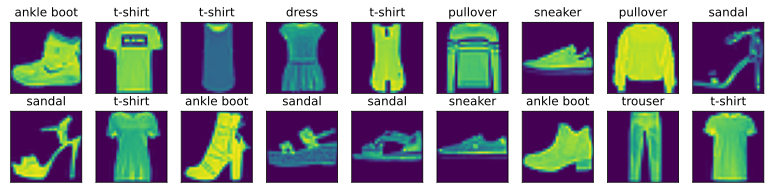

In [6]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28), 2, 9, titles=get_fashion_mnist_labels(y))

In [7]:
batch_size = 256

def get_dataloader_workers():
    return 8

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

In [8]:
timer = d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop(): .2f} sec'

' 1.35 sec'

In [9]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size, shuffle=False, 
                           num_workers=get_dataloader_workers()))


In [10]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X,y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break;

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [11]:
import torch
from IPython import display
from d2l import torch as d2l 


In [56]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [57]:
num_inputs = 784 
num_outputs = 10

W = torch.normal(0,0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [58]:
def softmax(X):
    x_exp = torch.exp(X)
    part = x_exp.sum(1, keepdim=True)
    return x_exp / part

In [59]:
X = torch.normal(-1,1,size=(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1, keepdim=True)




(tensor([[0.2024, 0.1696, 0.1115, 0.2668, 0.2499],
         [0.1677, 0.1062, 0.2173, 0.3909, 0.1178]]),
 tensor([[1.],
         [1.]]))

In [60]:
y = torch.tensor([0, 2])  ## y is typically given as array of given class labels
y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]])   ## y_hat is the output of softmax is 
                                                          ## discrete probability density for each class  
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [61]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y)),y])   

In [62]:
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### Classification Accuracy
- classification 예측 (y_hat)은 각 class에 대한 확률 값의 vector 형태로 출력됨. 
- 이중에 제일 큰 확률을 같는 값의 index (argmax) = class 
- label과 비교하여 정답의 갯수를 취함


In [63]:
def accuracy(y_hat, y):   #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

이렇게 얻어진 accuracy를 y의 갯수(샘플 갯수)로 나눔으로써 백분율을 구함

In [64]:
accuracy(y_hat, y) / len(y)

0.5

In [65]:
def evaluate_accuracy(net, data_iter): #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval() # Set the model to evaluation mode
    metric = Accumulator(2) # No. of correct predictions, no. of predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [66]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

### Training

In [67]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2] ## average loss & accuracy

        

In [73]:
class Animator: #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [74]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], 
                        ylim=[0.3,0.9],legend=['train loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc
    

In [75]:
lr = 0.1 
def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)


In [76]:
from torch import nn
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])),W) + b)
    

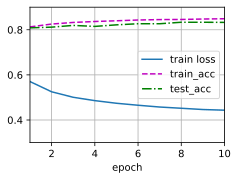

In [77]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


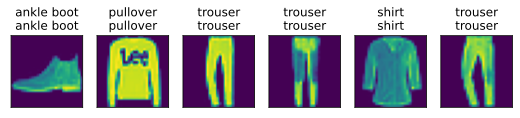

In [82]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## Softmax Regression using Pytorch API

In [86]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### Softmax의 (overflow)
- Softmax 함수의 exp()는 잠재적으로 매우 큰 값(표현의 한계) inf를 발생 시킬 수 있다. 
- 이 때문에 y_hat (prediction)에 nan, inf과 같은 결과가 생길 수 있음 

- 이를 우회하는 방법 중 하나는 exp 연산 전에 logit 중 가장 큰 값으로 모든 logit값을 빼주는 것을 생각해 볼 수 있는데 
- exp() 값이 매우 작아 0으로 rounded 될 경우 log(0)이 될 수 있기 때문에 cross entroy 연산에 문제가 생길 수 있음 


#### 따라서 이를 해결하는 방법으로 Softmax와 Cross Entropy를 병합함으로써 Log 와 Exp를 상쇄 시킬 수 있다.(LogSumExp trick)

In [87]:
loss = nn.CrossEntropyLoss(reduction='none')

In [89]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

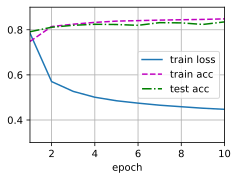

In [90]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)